In [11]:
import numpy as np
import pandas as pd
import os
import random
import cv2
import re
import json
import matplotlib.pyplot as plt

random.seed(42)

In [12]:
def circle_mask(size=(480, 480), border=0, fix=(0,0)):
    mask = np.zeros((size[0], size[1]), dtype=np.uint8) 
    mask = cv2.circle(mask, (int(size[0]/2 -1), int(size[1]/2 -1)), int(size[0]/2 -13), 1, thickness=-1)
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    return mask

def overall_mask(size=(480, 480), border=0, fix=(0,0)):
    """
        used to filter center circular area of a given image,
        corresponding to the AllSight surface area
    """
    m = np.zeros((size[1], size[0]))

    m_center = (size[0] // 2 - fix[0], size[1] // 2 - fix[1])
    m_radius = (min(size[0], size[1]) // 2 - border - max(abs(fix[0]), abs(fix[1]))) 
    m = cv2.circle(m, m_center, m_radius, 255, -1)
    m /= 255
    m = m.astype(np.float32)
    mask = np.stack([m, m, m], axis=2)

    return mask

def inv_foreground(ref_frame, diff, offset=0.0):
        
        ref_frame = np.float32(ref_frame)
        diff = np.float32(diff)
        diff = (diff*2 - 255) 
        frame = ref_frame + diff
        
        mask = circle_mask()
        frame = (frame).astype(np.uint8)
        frame = frame*mask

        return frame
    
def foreground(frame, ref_frame, offset=0.0):
        
        frame = np.float32(frame)
        ref_frame = np.float32(ref_frame)

        diff_frame = frame - ref_frame
        # diff_frame = diff_frame / 255.0 + 1
        diff_frame = diff_frame  + 255
        
        min_value = np.min(diff_frame)
        max_value = np.max(diff_frame)
        
        mask = circle_mask()
        diff_frame = (diff_frame/2).astype(np.uint8)
        # diff_frame[mask == 0] = 0
        diff_frame = diff_frame*mask
        return diff_frame

In [13]:
def display_images(images, titles):
    plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, 4, i)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [14]:
json_path_real = '/home/roblab20/Documents/repose/Allsight_sim2real/allsight_sim2real/datasets/data_Allsight/json_data/real_train_8_transformed.json'
json_path_sim = '/home/roblab20/Documents/repose/Allsight_sim2real/allsight_sim2real/datasets/data_Allsight/json_data/sim_train_8_transformed.json'

copy_to_path = '/home/roblab20/Documents/repose/Allsight_sim2real/allsight_sim2real/datasets/data_Allsight/diff_images/exp_8/train/'

# Create the directory if it doesn't exist
if not os.path.exists(copy_to_path):
    os.makedirs(copy_to_path)

df_real = pd.read_json(json_path_real).transpose()
df_real['diff_frame'] = df_real['frame']

df_sim = pd.read_json(json_path_sim).transpose()
df_sim['diff_frame'] = df_sim['frame']

In [15]:
idx = 4
frame = (cv2.imread(df_real['frame'][idx])).astype(np.uint8)
ref_frame = (cv2.imread(df_real['ref_frame'][idx])).astype(np.uint8)

diff_frame = foreground(frame, ref_frame, offset=0.2)
save_path = os.path.join(copy_to_path, f'diff_real_{idx}.jpg')

cv2.imwrite(save_path, diff_frame)
df_real['diff_frame'][idx] = save_path



In [16]:
ref_frame = (cv2.imread(df_real['ref_frame'][15])).astype(np.uint8)

composed_frame = inv_foreground(ref_frame, diff_frame, offset=0.2)

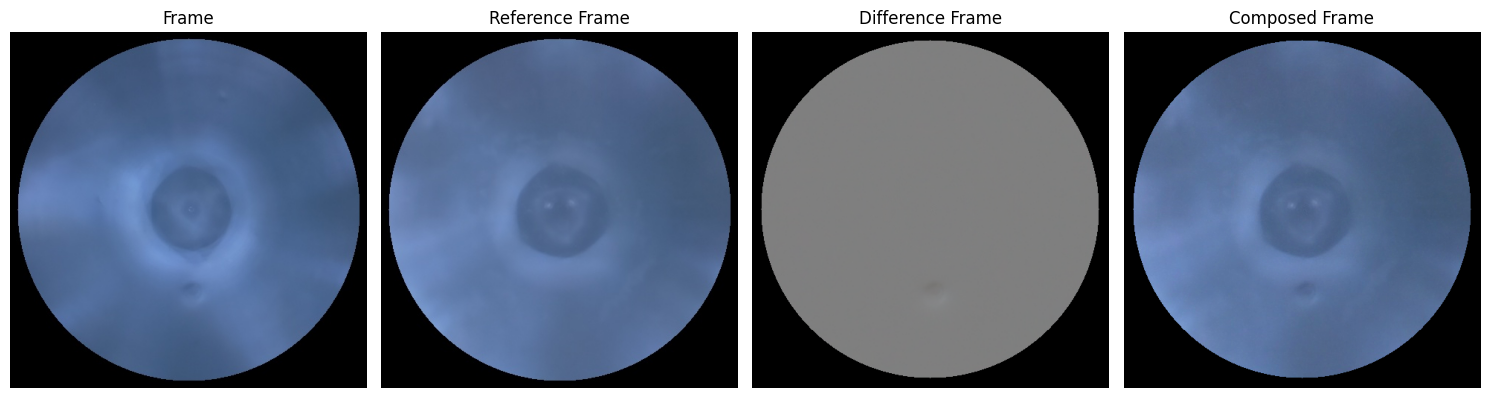

In [17]:
# Display the images using the function
images = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(ref_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(diff_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(composed_frame, cv2.COLOR_BGR2RGB)]
titles = ['Frame', 'Reference Frame', 'Difference Frame', 'Composed Frame']

display_images(images, titles)

In [24]:
idx = 15
frame = (cv2.imread(df_sim['frame'][idx])).astype(np.uint8)
ref_frame = (cv2.imread(df_sim['ref_frame'][idx])).astype(np.uint8)

diff_frame = foreground(frame, ref_frame, offset=0.2)
save_path = os.path.join(copy_to_path, f'diff_sim_{idx}.jpg')

cv2.imwrite(save_path, diff_frame)
df_sim['diff_frame'][idx] = save_path

In [25]:
ref_frame = (cv2.imread(df_sim['ref_frame'][15])).astype(np.uint8)

composed_frame = inv_foreground(ref_frame, diff_frame, offset=0.2)

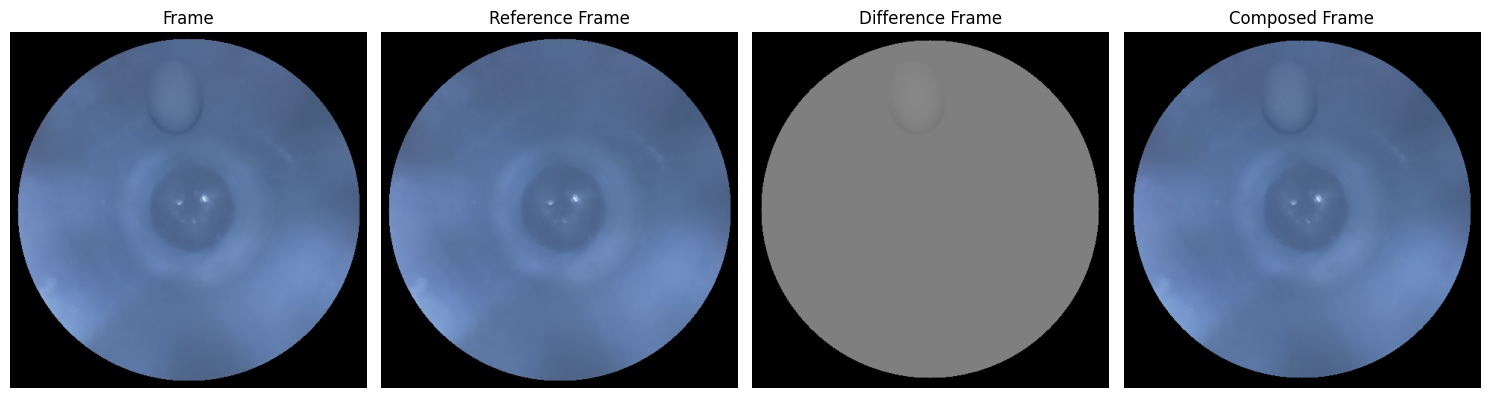

In [26]:
# Display the images using the function
images = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(ref_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(diff_frame, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(composed_frame, cv2.COLOR_BGR2RGB)]
titles = ['Frame', 'Reference Frame', 'Difference Frame', 'Composed Frame']

display_images(images, titles)

In [21]:
for idx in range(100):
    frame = (cv2.imread(df_real['frame'][idx])).astype(np.uint8)
    ref_frame = (cv2.imread(df_real['ref_frame'][idx])).astype(np.uint8)
    
    diff_image = foreground(frame, ref_frame, offset=0.2)
    save_path = os.path.join(copy_to_path, f'diff_real_{idx}.jpg')
    
    cv2.imwrite(save_path, diff_image)
    df_real['diff_frame'][idx] = save_path
    
for idx in range(100):
    frame = (cv2.imread(df_sim['frame'][idx])).astype(np.uint8)
    ref_frame = (cv2.imread(df_sim['ref_frame'][idx])).astype(np.uint8)
    
    diff_image = foreground(frame, ref_frame, offset=0.2)
    save_path = os.path.join(copy_to_path, f'diff_sim_{idx}.jpg')
    
    cv2.imwrite(save_path, diff_image)
    df_sim['diff_frame'][idx] = save_path

In [ ]:
# Save df to json
to_dict = {}
for index, row in list(df_data.iterrows()):
    to_dict[index] = dict(row)
with open(f'{json_path}', 'w') as json_file:
    json.dump(to_dict, json_file, indent=3)
    print("[INFO] json saved")